In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import torch.nn as nn
from physics import *
from plotter import *

In [2]:
def time_loss_fun(Y, T, F, scale=None):
    """
    Y: final state (6D: x, y, theta, s, omega, t)
    T: target (5D)
    F: list of forcings
    """
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T) * scale
    diff[2] = angle_diff(Y[2], T[2])
    target_loss = pt.dot(diff, diff)                # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(F[:,0:2]**2)                  # loss by using too much force
    return target_loss, time_loss, l2_loss

def get_time_forcing(V, F):
    """
    Returns true forcings from logits
    """
    limits_min = pt.tensor([-0.8, -0.8, 0.001], device=F.device)
    limits_max = pt.tensor([0.8, 0.8, 0.25], device=F.device)
    return limits_min + (limits_max - limits_min) * pt.sigmoid(F)

# Compute a path while modifing V_mat and F_mat inplace
def compute_time_path_autograd(V0, F_request, target):
    """
    Computes entire path given initial position and logits of forcings. Computes loss given target.
    V0: initial position
    F_logits: logits of forcing terms
    target: target position in 5D space
    """

    V_list = [V0]
    F_true = []

    for i in range(F_request.shape[0]):
        F_true.append(get_time_forcing(V_list[i], F_request[i]))
        V_list.append(V_step(V_list[i], F_true[i]))

    loss = time_loss_fun(V_list[-1], target, pt.stack(F_true))

    return V_list, loss


def optimizeTimePath(v0, target, F_logits, iters=500, fine_tuning_steps=50, plot_freq=50,
        lr=9e-2, l2_rate=-1e0, time_rate=2e-8, reverse_rate=0.0, show_logs=True):
    """
    Iteratively performs GD to optimize forcings
    
    v0: starting tensor in 6d (v0[5]=0)
    target: ending tensor in 5d
    checkpoint_dof: num_checkpoints x 3 tensor containing learnable dfs at start of segments
    F_logits: (n_steps, 3) learnable parameter
    """
    
    num_records = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1
    n_steps = F_logits.shape[0]
    V_records = pt.zeros((num_records, n_steps+1, 5)) # records of positions
    F_records = pt.zeros((num_records, n_steps, 3))   # records of true forcings
    ts_records = pt.zeros((num_records, n_steps+1))   # records of timestamps
    loss_records = pt.zeros((num_records, 4))         # records of each loss component

    optim = pt.optim.Adam([F_logits])

    for i in range(iters):
        x = i / (iters - fine_tuning_steps)
        lr = to_lambda(lr)
        l2_rate = to_lambda(l2_rate)
        time_rate = to_lambda(time_rate)
        reverse_rate = to_lambda(reverse_rate)

        is_record_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
        record_idx = i // plot_freq
        
        optim.zero_grad()
        V_mat, (target_loss, time_loss, l2_loss) = compute_time_path_autograd(v0, F_logits, target)


        dist = target_loss ** 0.5

        l2_coef = l2_rate(x, target_loss) if i < iters-fine_tuning_steps else 0
        time_coef = time_rate(x, target_loss) if i < iters-fine_tuning_steps else 0
        reverse_coef = reverse_rate(x, target_loss) if i < iters-fine_tuning_steps else 0

        reverse_loss = pt.mean(pt.exp(-5 * pt.stack(V_mat)[:,3]))


        loss = target_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss
        loss.backward()

        # set optimizer learning rate and take step
        step_lr = lr(x, target_loss)
        for param_group in optim.param_groups:
            param_group['lr'] = step_lr
        optim.step()
        

        if is_record_step:
            if show_logs:
                print(f"Iteration {i+1}, Target Dist: {dist:.3f}, End Time: {time_loss:.3f}, L2: {l2_loss:.3f}")
            traj, ts = to_tensor(V_mat)
            V_records[record_idx,:,:] = traj
            F_records[record_idx,:,:] = get_time_forcing(pt.stack(V_mat[:-1]), F_logits)
            ts_records[record_idx,:] = ts
            loss_records[record_idx,:] = pt.tensor([target_loss, time_loss, l2_loss, reverse_loss])
    
    return F_logits, F_records, V_records, ts_records, loss_records

In [3]:
t0 = 0
v0 = pt.tensor([0, 0, 0.2, 1, 1, t0], requires_grad=True)
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
n_steps = 32

F_mat = nn.Parameter(pt.zeros((n_steps, 3)))

print(f'Path has {n_steps} steps')

F_logits = nn.Parameter(pt.zeros((n_steps, 3)))

F_logits, F_true, V_mat, ts_records, loss_logs = optimizeTimePath(v0, target, F_logits, iters=1000)

Path has 32 steps
Iteration 50, Target Dist: 1.220, End Time: 4.021, L2: 0.302
Iteration 100, Target Dist: 0.301, End Time: 4.359, L2: 0.326
Iteration 150, Target Dist: 0.246, End Time: 4.460, L2: 0.334
Iteration 200, Target Dist: 0.199, End Time: 4.458, L2: 0.340
Iteration 250, Target Dist: 0.098, End Time: 4.479, L2: 0.348
Iteration 300, Target Dist: 0.029, End Time: 4.486, L2: 0.368
Iteration 350, Target Dist: 0.020, End Time: 4.459, L2: 0.391
Iteration 400, Target Dist: 0.024, End Time: 4.429, L2: 0.413
Iteration 450, Target Dist: 0.028, End Time: 4.402, L2: 0.433
Iteration 500, Target Dist: 0.031, End Time: 4.379, L2: 0.452
Iteration 550, Target Dist: 0.033, End Time: 4.360, L2: 0.468
Iteration 600, Target Dist: 0.033, End Time: 4.344, L2: 0.483
Iteration 650, Target Dist: 0.033, End Time: 4.330, L2: 0.497
Iteration 700, Target Dist: 0.033, End Time: 4.318, L2: 0.509
Iteration 750, Target Dist: 0.033, End Time: 4.306, L2: 0.520
Iteration 800, Target Dist: 0.032, End Time: 4.296, L

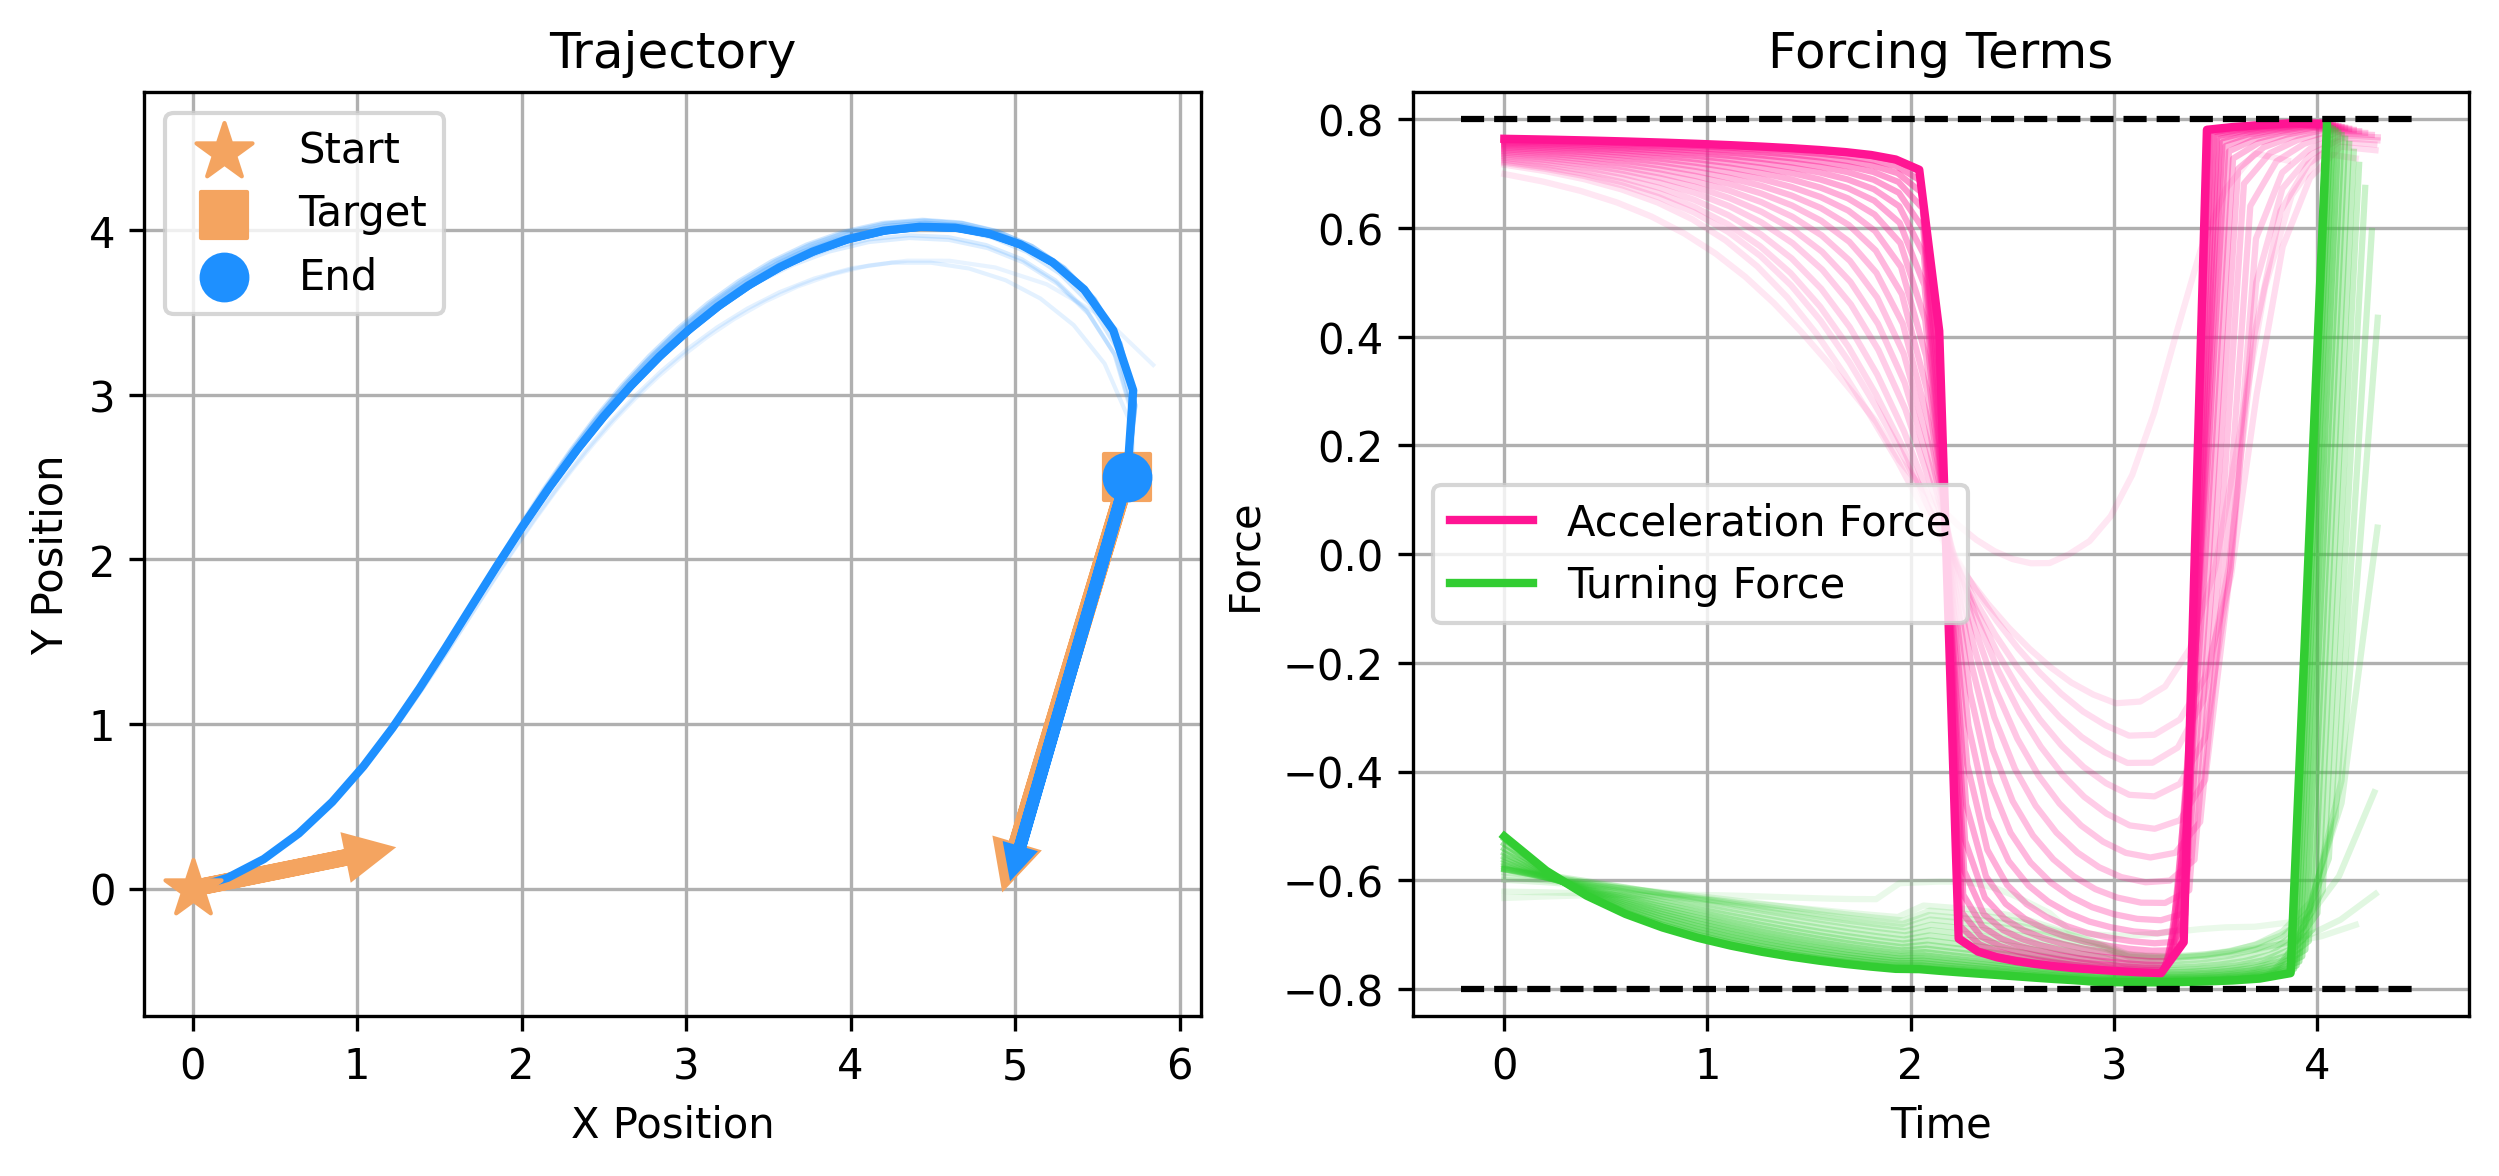

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_true, ts_records, ax=ax2)
plt.show()

### Testing reverse loss

Path has 32 steps
Iteration 50, Target Dist: 1.407, End Time: 6.437, L2: 0.232
Iteration 100, Target Dist: 0.420, End Time: 7.158, L2: 0.292
Iteration 150, Target Dist: 0.256, End Time: 7.237, L2: 0.327
Iteration 200, Target Dist: 0.175, End Time: 7.303, L2: 0.355
Iteration 250, Target Dist: 0.127, End Time: 7.360, L2: 0.379
Iteration 300, Target Dist: 0.096, End Time: 7.403, L2: 0.402
Iteration 350, Target Dist: 0.075, End Time: 7.435, L2: 0.423
Iteration 400, Target Dist: 0.061, End Time: 7.459, L2: 0.443
Iteration 450, Target Dist: 0.053, End Time: 7.476, L2: 0.461
Iteration 500, Target Dist: 0.049, End Time: 7.485, L2: 0.477
Iteration 550, Target Dist: 0.047, End Time: 7.488, L2: 0.491
Iteration 600, Target Dist: 0.047, End Time: 7.486, L2: 0.505
Iteration 650, Target Dist: 0.049, End Time: 7.482, L2: 0.520
Iteration 700, Target Dist: 0.051, End Time: 7.480, L2: 0.535
Iteration 750, Target Dist: 0.049, End Time: 7.481, L2: 0.548
Iteration 800, Target Dist: 0.047, End Time: 7.487, L

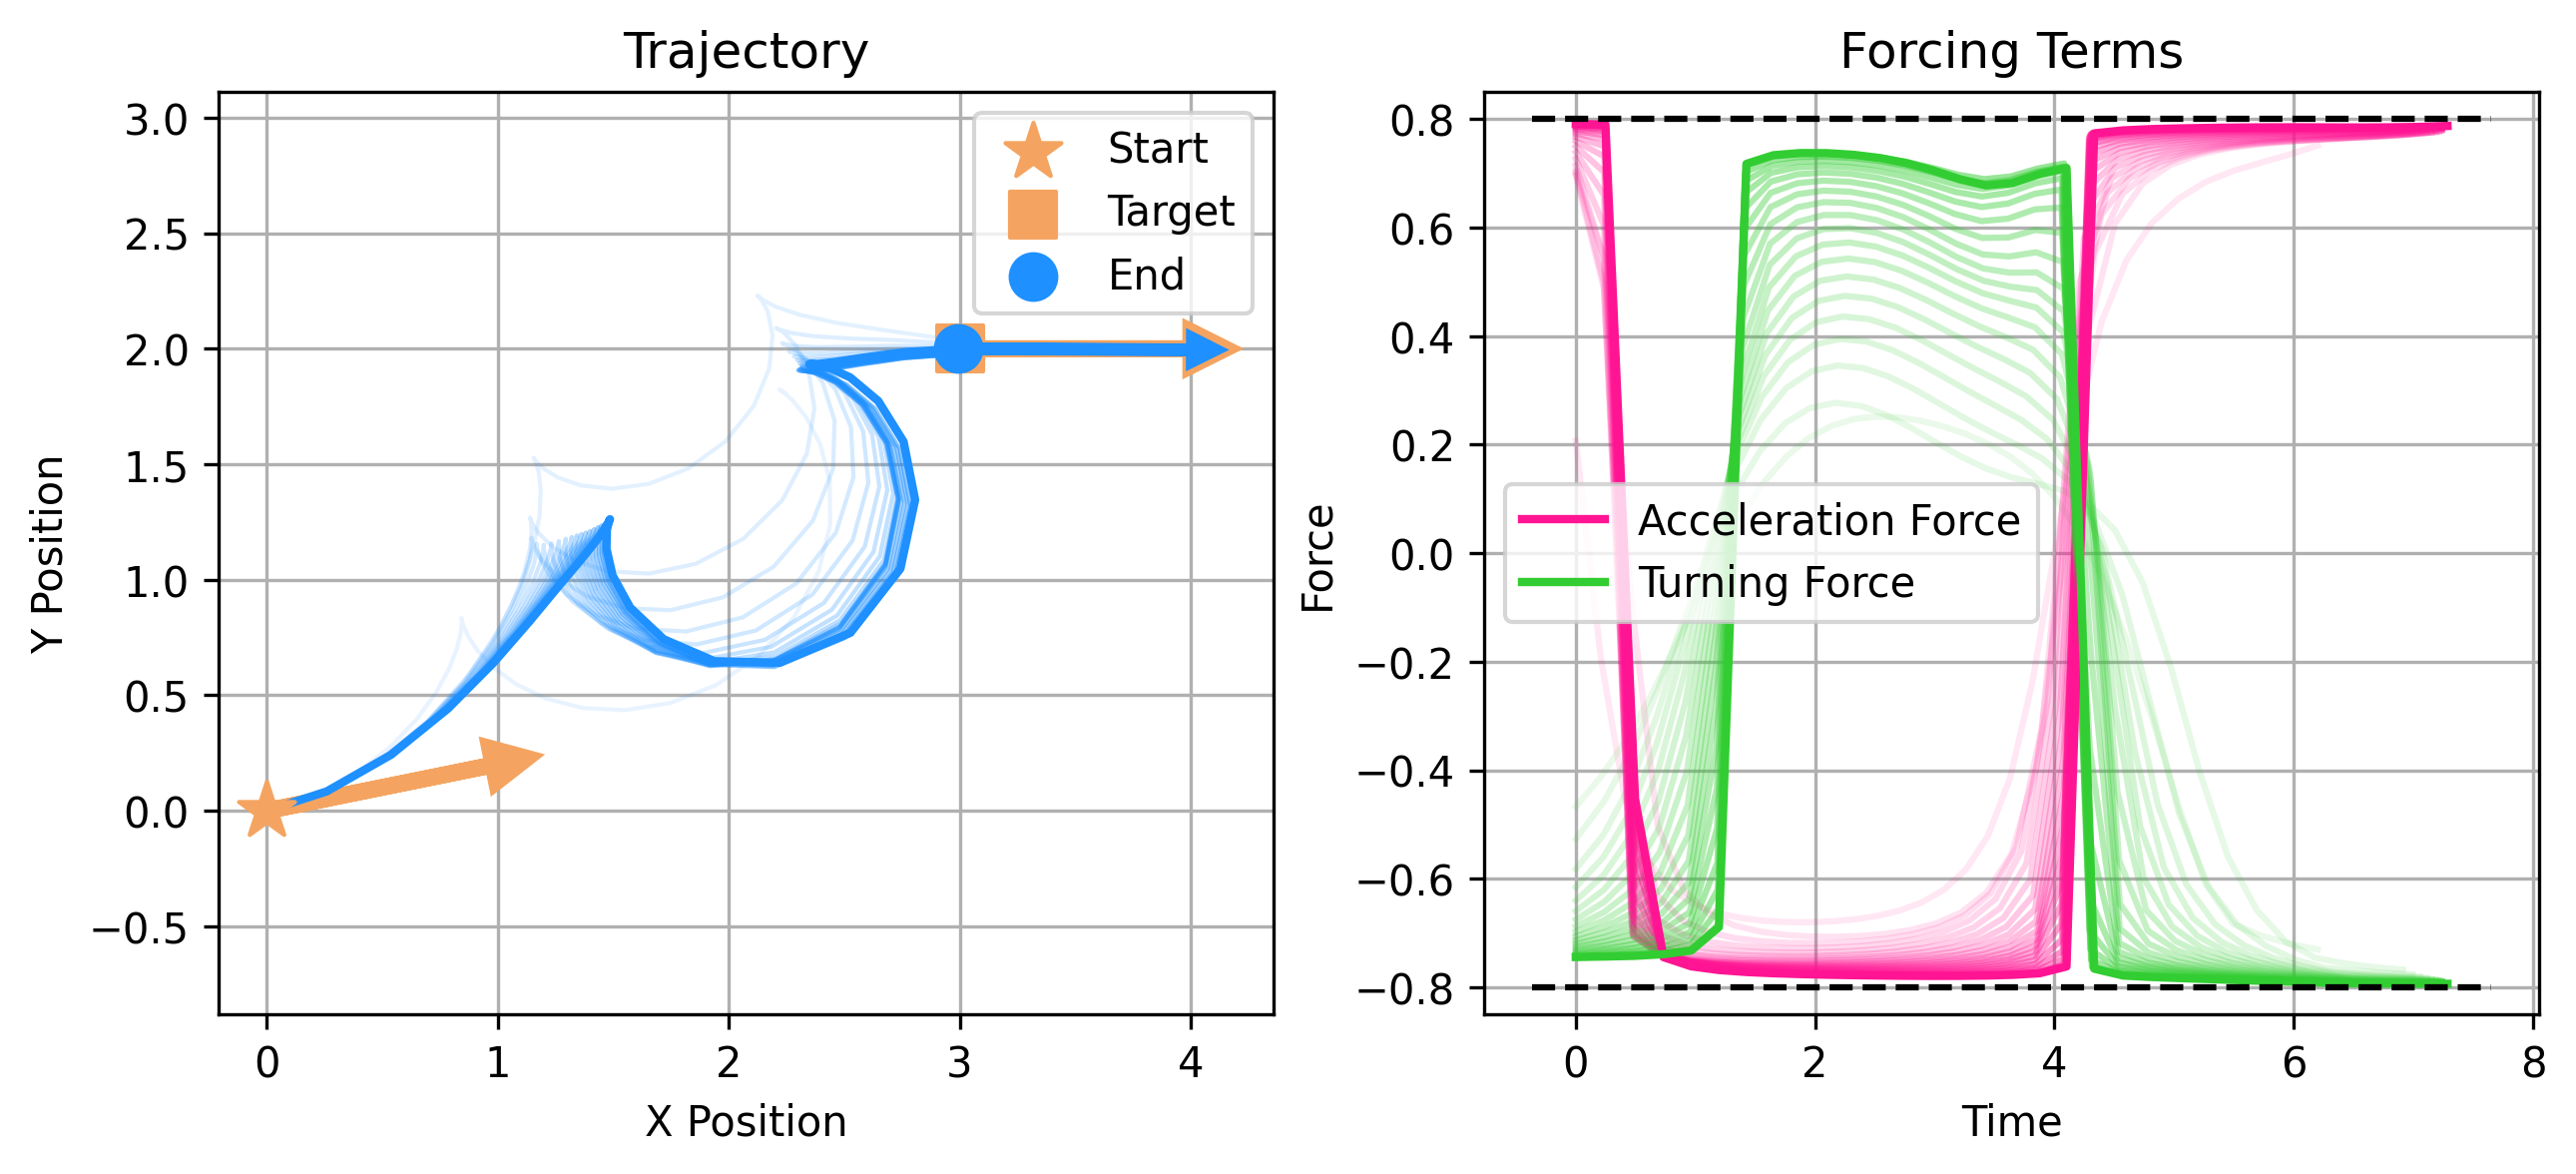

In [5]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = 32

print(f'Path has {n_steps} steps')

F_logits = nn.Parameter(pt.zeros((n_steps, 3)))

F_logits, F_true, V_mat, ts_records, loss_logs = optimizeTimePath(v0, target, F_logits,
                                                                  reverse_rate=0, iters=1000)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_true, ts_records, ax=ax2)
plt.show()

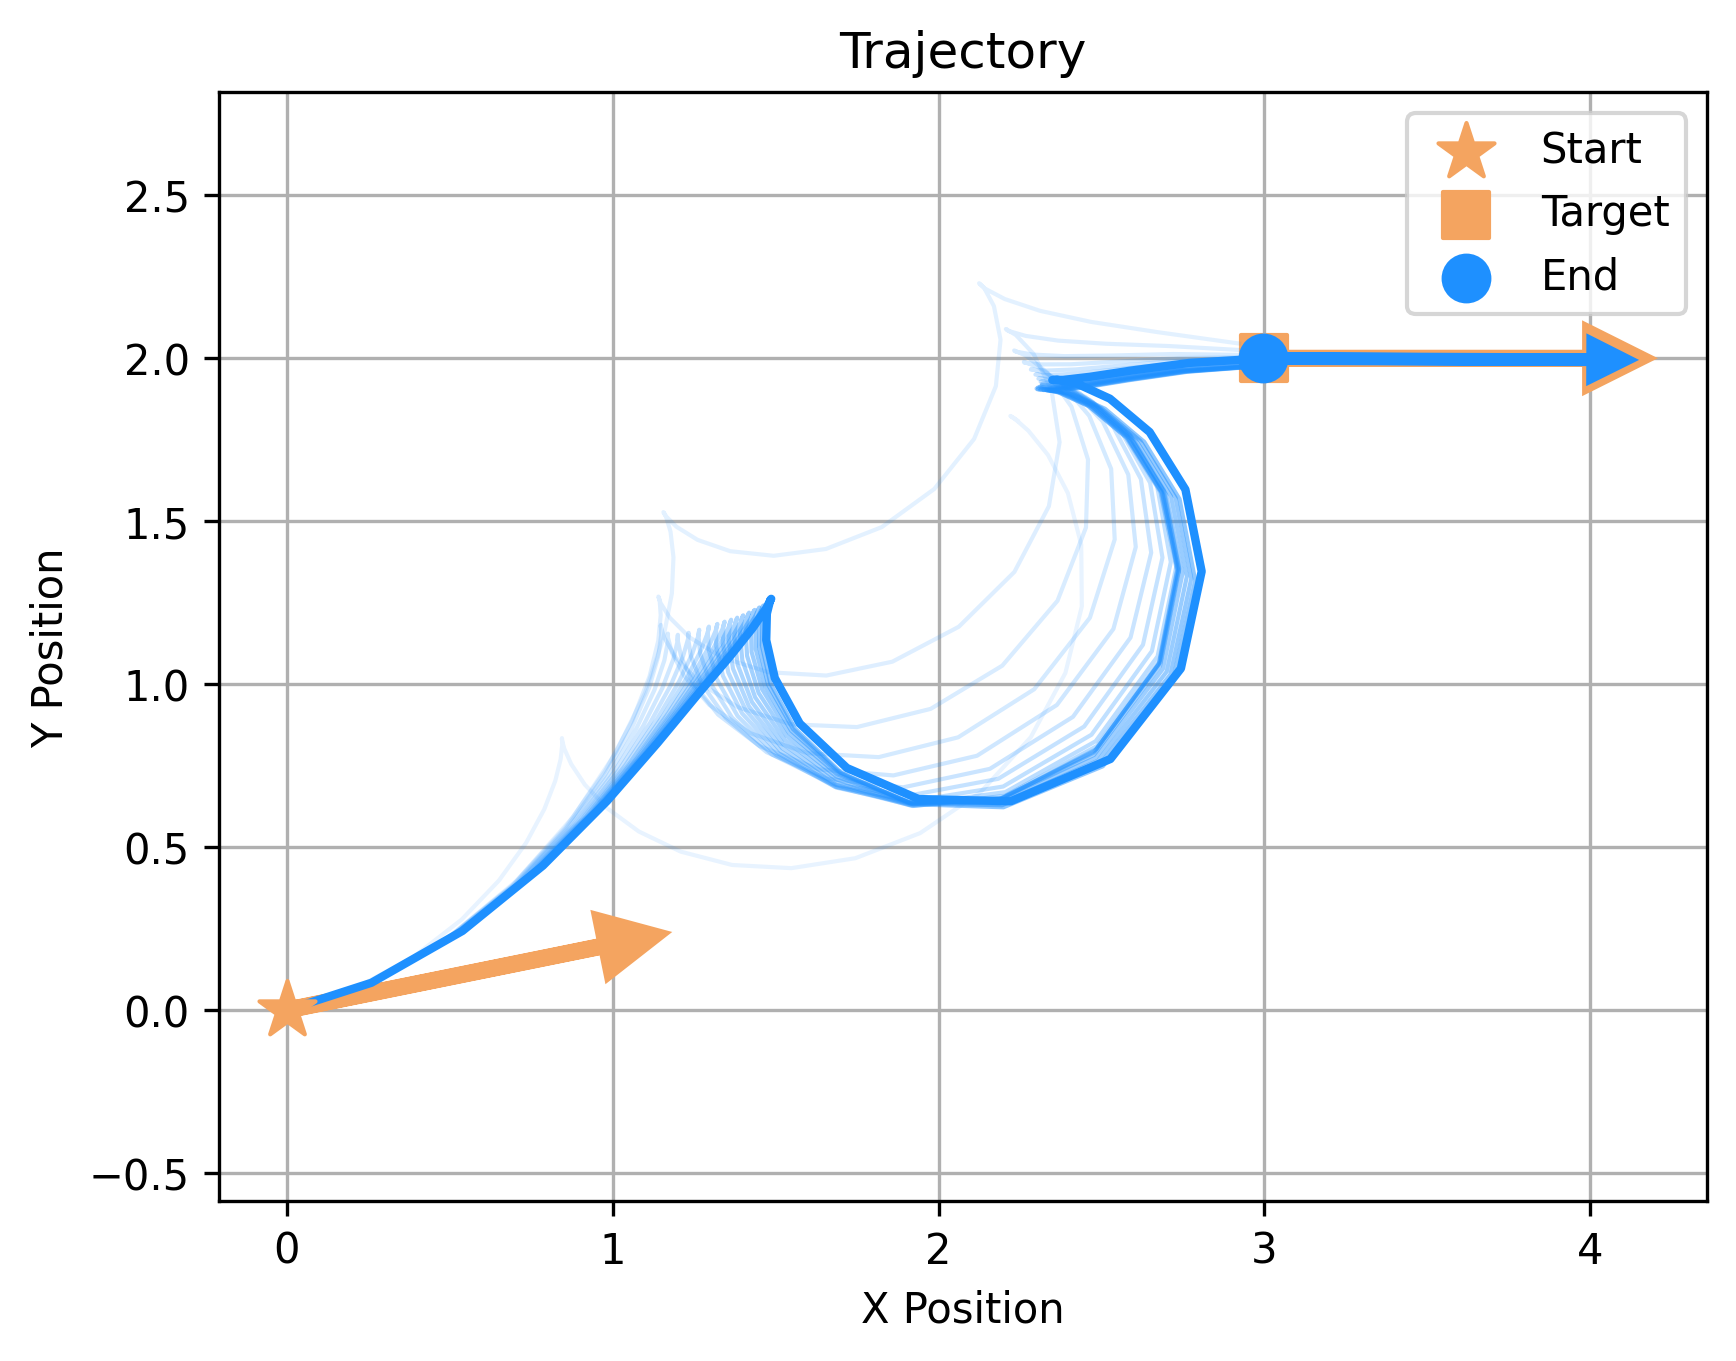

In [6]:
fig, ax = plt.subplots(dpi=300)
plot_traj(V_mat, target, ax=ax)
plt.show()

Path has 32 steps
Iteration 50, Target Dist: 1.109, End Time: 6.274, L2: 0.227
Iteration 100, Target Dist: 0.551, End Time: 6.867, L2: 0.291
Iteration 150, Target Dist: 0.215, End Time: 6.810, L2: 0.293
Iteration 200, Target Dist: 0.107, End Time: 6.763, L2: 0.305
Iteration 250, Target Dist: 0.071, End Time: 6.687, L2: 0.320
Iteration 300, Target Dist: 0.054, End Time: 6.616, L2: 0.338
Iteration 350, Target Dist: 0.046, End Time: 6.553, L2: 0.359
Iteration 400, Target Dist: 0.044, End Time: 6.499, L2: 0.380
Iteration 450, Target Dist: 0.042, End Time: 6.454, L2: 0.401
Iteration 500, Target Dist: 0.040, End Time: 6.418, L2: 0.423
Iteration 550, Target Dist: 0.037, End Time: 6.390, L2: 0.444
Iteration 600, Target Dist: 0.035, End Time: 6.369, L2: 0.465
Iteration 650, Target Dist: 0.034, End Time: 6.353, L2: 0.485
Iteration 700, Target Dist: 0.032, End Time: 6.339, L2: 0.503
Iteration 750, Target Dist: 0.030, End Time: 6.326, L2: 0.519
Iteration 800, Target Dist: 0.030, End Time: 6.316, L

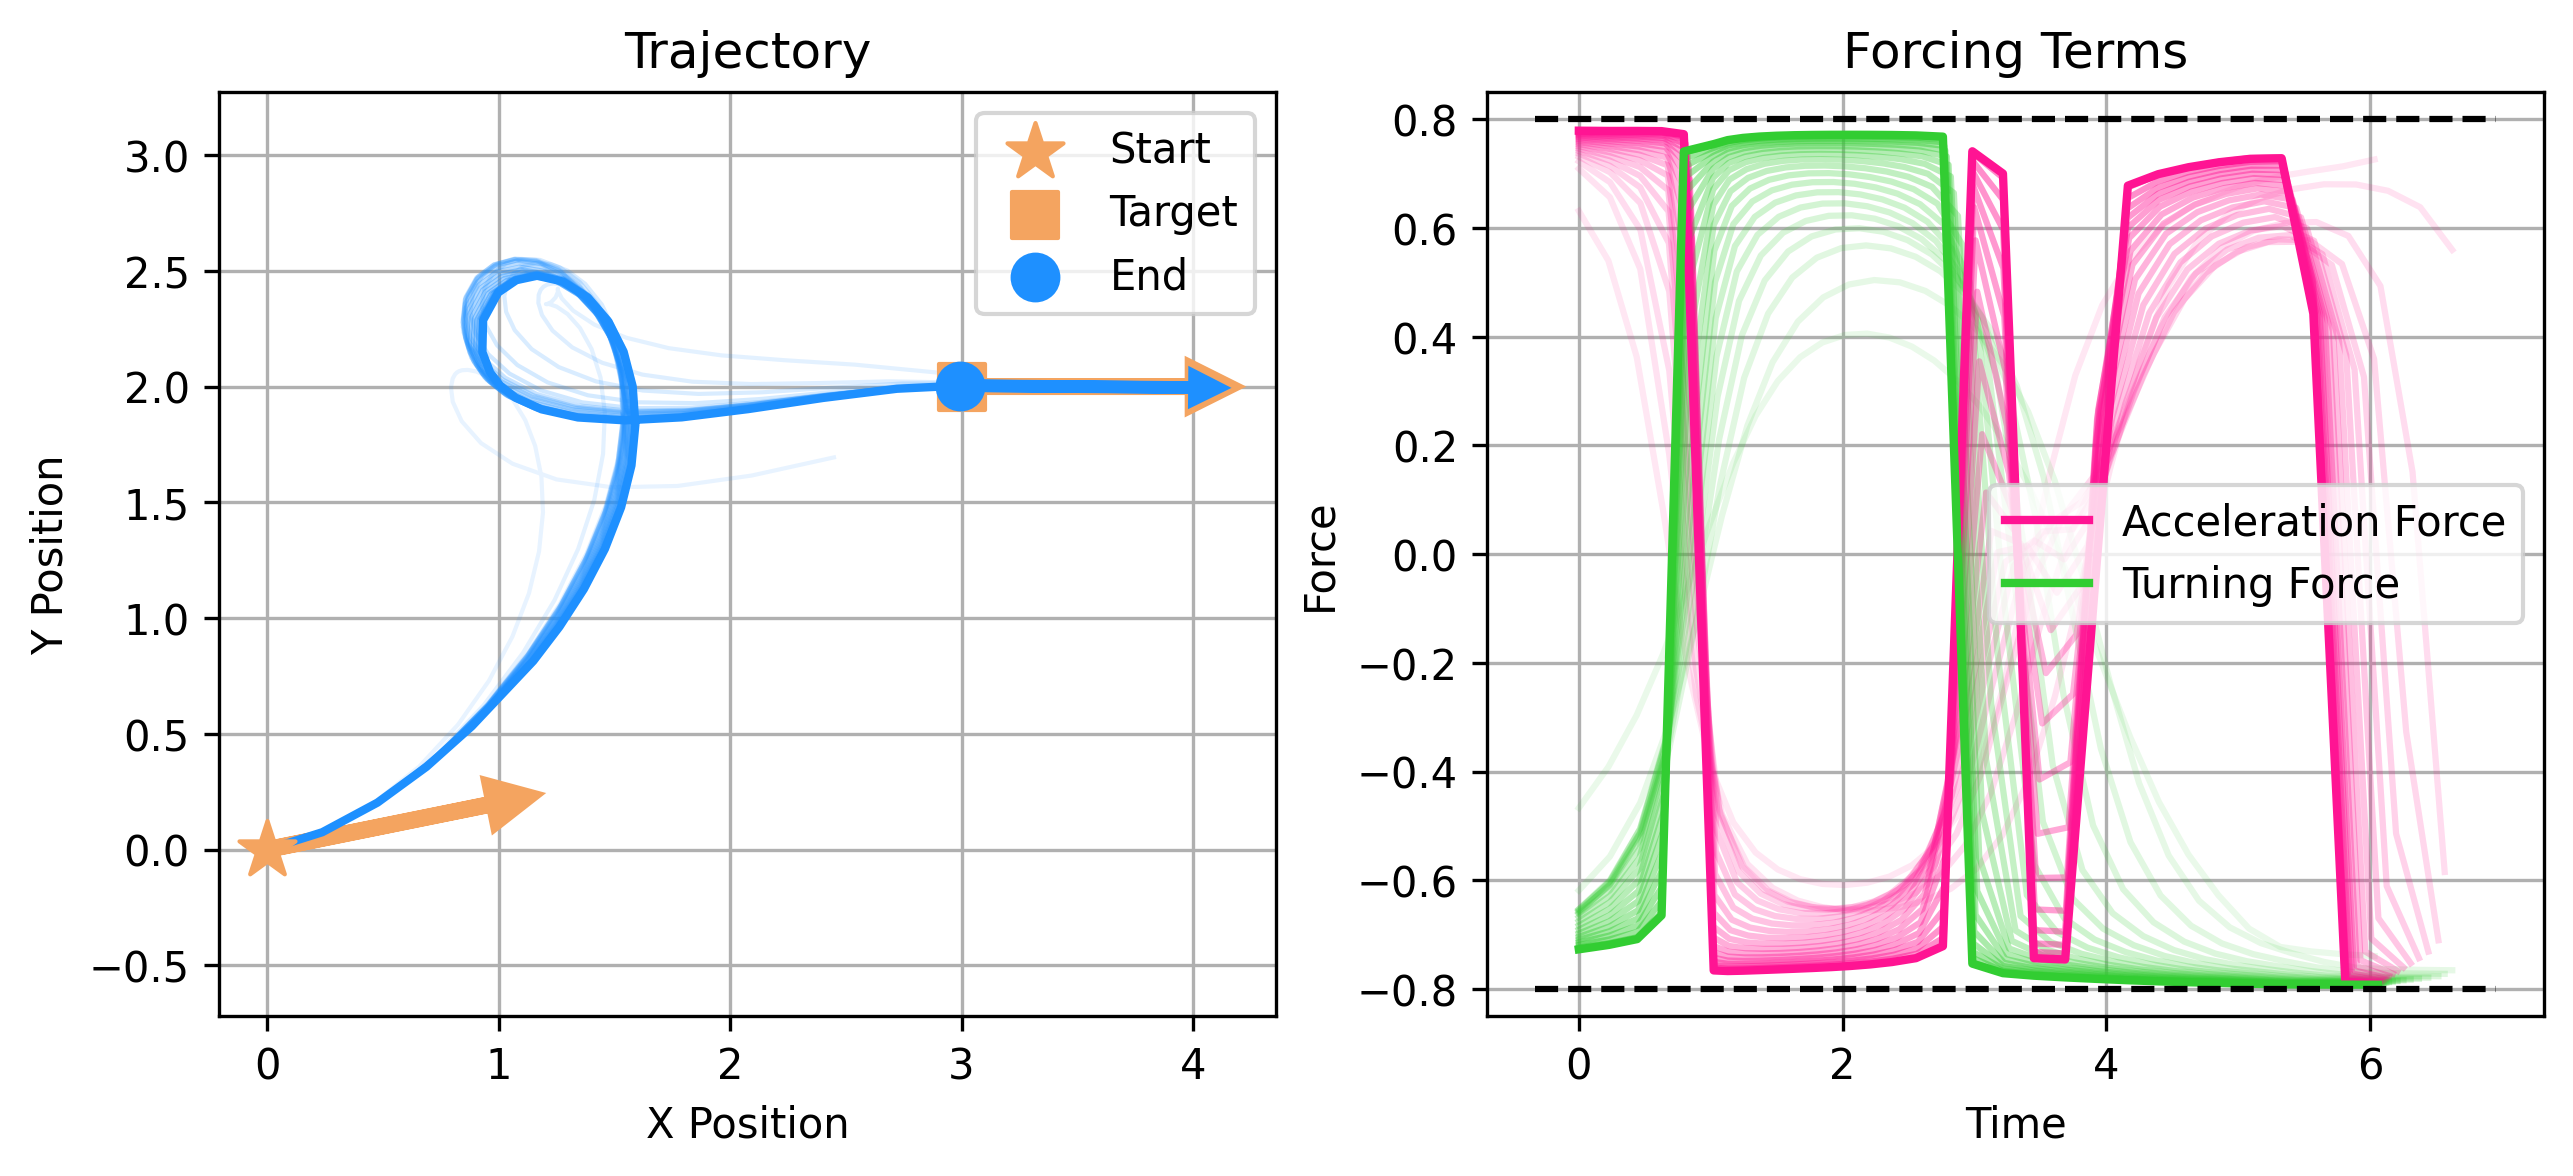

In [7]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
target = pt.tensor([3, 2, 0,1,-0.5])
n_steps = 32

print(f'Path has {n_steps} steps')

F_logits = nn.Parameter(pt.zeros((n_steps, 3)))

F_logits, F_true, V_mat, ts_records, loss_logs = optimizeTimePath(v0, target, F_logits,
                                                                  reverse_rate=0.5, iters=1000)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_mat, target, ax=ax1)
plot_forcing(F_true, ts_records, ax=ax2)
plt.show()

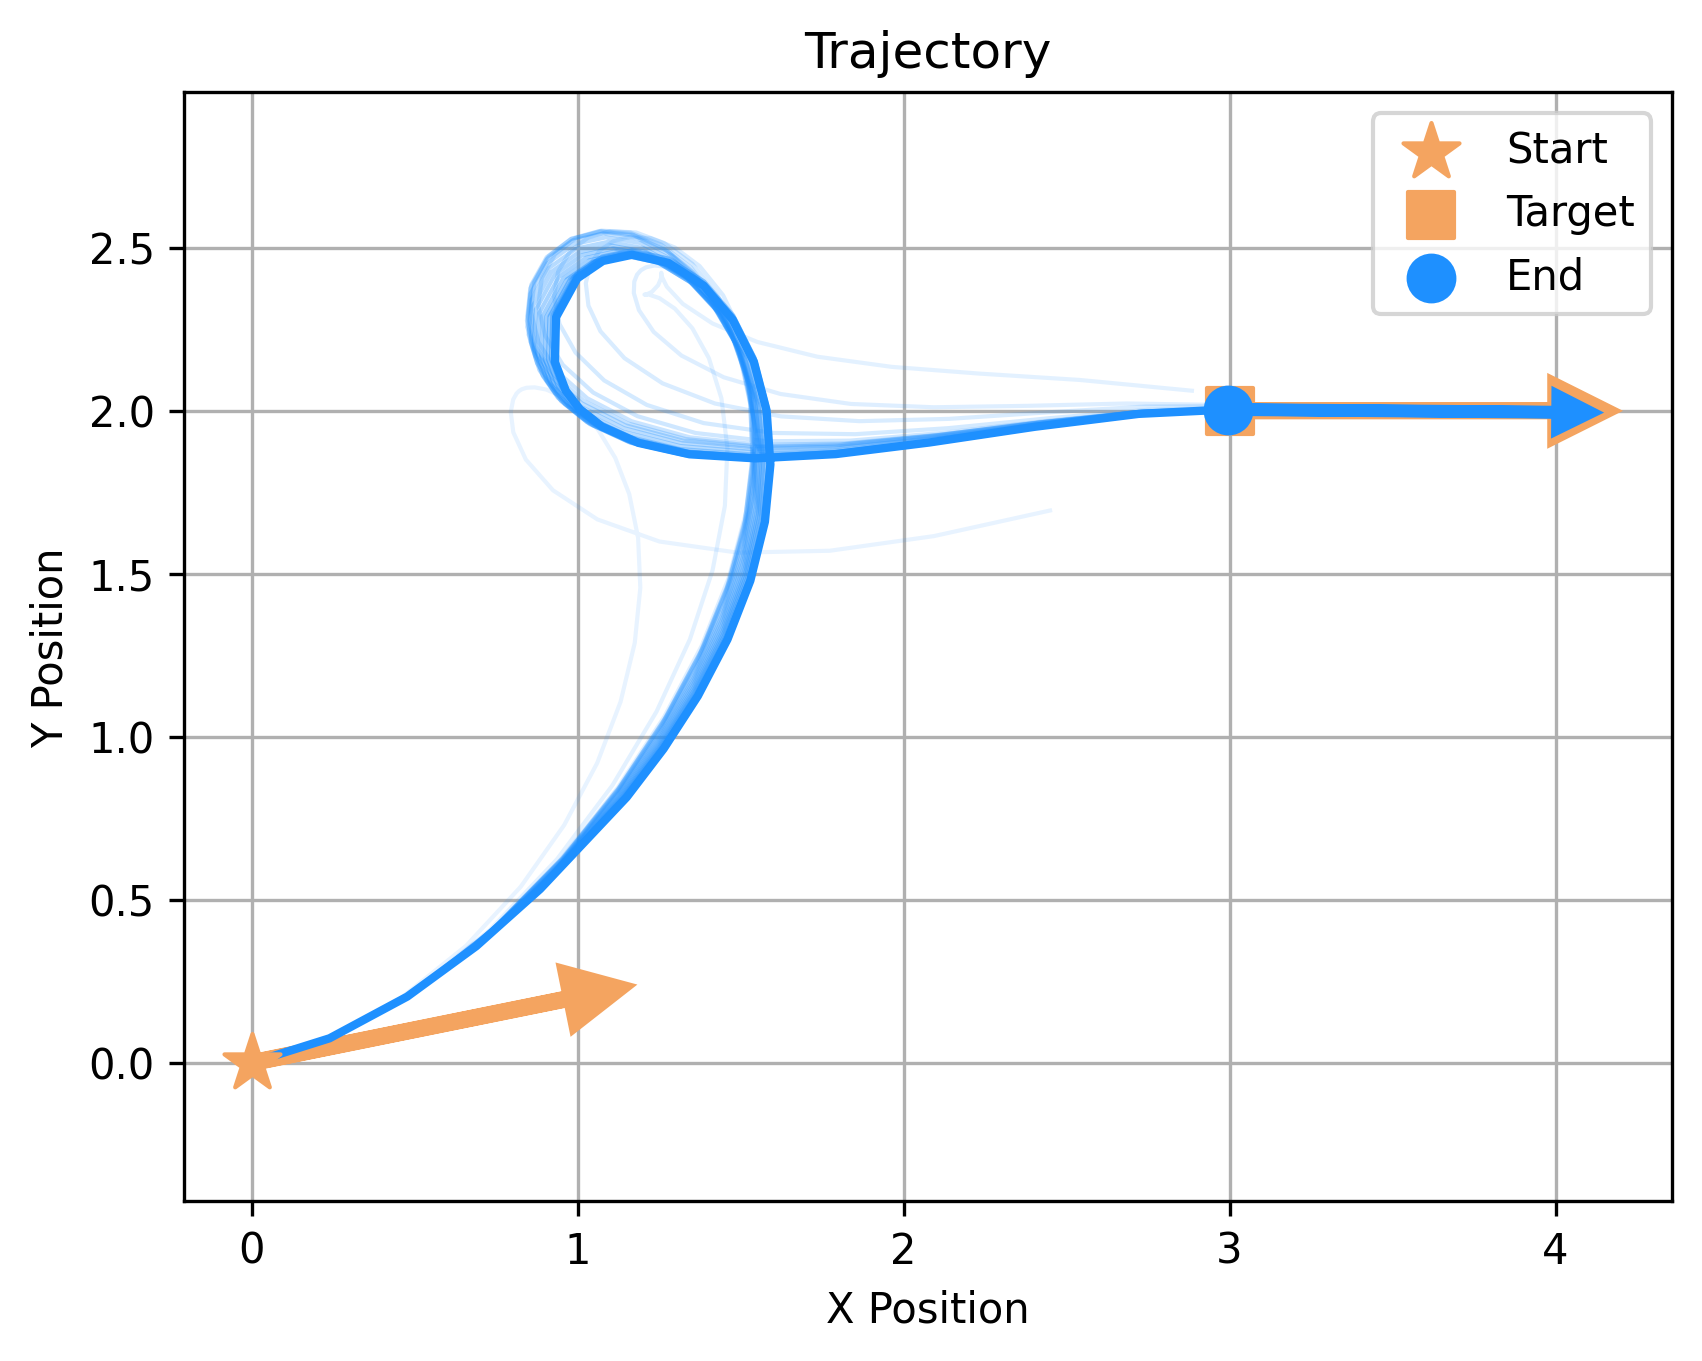

In [8]:
fig, ax = plt.subplots(dpi=300)
plot_traj(V_mat, target, ax=ax)
plt.show()